In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import librosa

from fma_related.fma import utils

import pickle

In [2]:
# Load metadata and features.
raw_tracks = utils.load('./data/fma_metadata/tracks.csv')
raw_genres = utils.load('./data/fma_metadata/genres.csv')
raw_features = utils.load('./data/fma_metadata/features.csv')
raw_echonest = utils.load('./data/fma_metadata/echonest.csv')

raw_tracks.shape, raw_genres.shape, raw_features.shape, raw_echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:
tracks = raw_tracks.copy()
features = raw_features.copy()

In [4]:
# flatten_columns

tracks.columns = list(map("_".join, tracks.columns))
features.columns = list(map("_".join, features.columns))

In [5]:
tracks["track_genre_top"].value_counts().nlargest(5)

track_genre_top
Rock            14182
Experimental    10608
Electronic       9372
Hip-Hop          3552
Folk             2803
Name: count, dtype: int64

In [6]:
using_genres = tracks["track_genre_top"].value_counts().nlargest(5).index
using_tracks = tracks[tracks["track_genre_top"].isin(using_genres)]

train_set = using_tracks.loc[:, ["track_genre_top"]].merge(
    features, right_index=True, left_index=True
)
train_set = train_set.loc[:, filter(lambda x: not x.startswith("rmse"), train_set.columns)]

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

In [8]:
train_x_set = train_set.drop(columns=["track_genre_top"])
train_y_set = train_set.loc[:, ["track_genre_top"]].astype(str)

In [9]:
pca.fit(train_x_set)
pca_train_x = pd.DataFrame(
    pca.transform(train_x_set), columns=["pca_1", "pca_2"], index=train_x_set.index
)

In [10]:
pca_train = pca_train_x.merge(train_y_set, right_index=True, left_index=True)

In [11]:
stratified_sample = pca_train.groupby("track_genre_top", group_keys=False).apply(lambda x: x.sample(500))

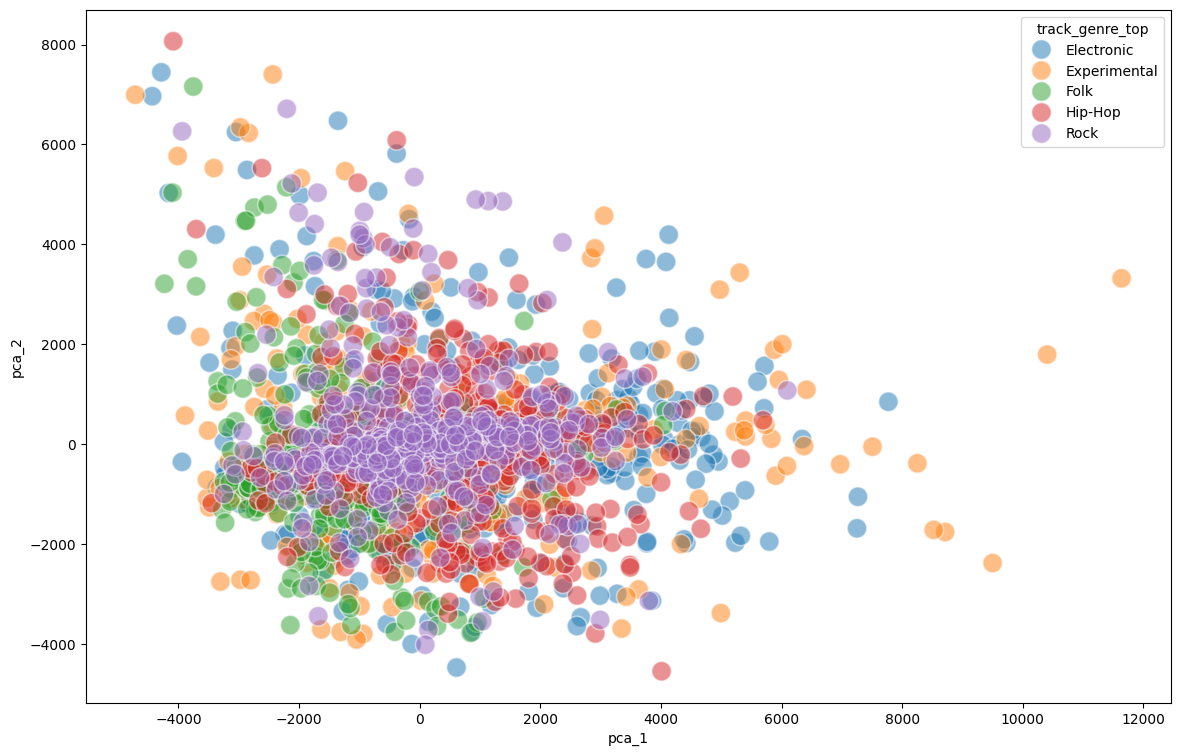

In [12]:
plt.figure(figsize=(14, 9))
sns.scatterplot(x="pca_1", y="pca_2", hue="track_genre_top", data=stratified_sample, alpha=0.5, s=200)
plt.show()

In [13]:
from sklearn.cluster import KMeans

stratified_sample = pca_train.groupby("track_genre_top", group_keys=False).apply(
    lambda x: x.sample(2000)
)
clustered = stratified_sample.loc[:, ["pca_1", "pca_2"]].copy()

kmeans = KMeans(n_clusters=5, n_init="auto")
kmeans.fit(clustered)

clustered["cluster"] = kmeans.predict(clustered)

In [14]:
cluster_genre = clustered.merge(
    stratified_sample["track_genre_top"], right_index=True, left_index=True
)

In [15]:
cluster_genre_gb = cluster_genre.groupby("track_genre_top")["cluster"]

In [16]:
pivot_tb = (
    cluster_genre_gb.value_counts()
    .reset_index()
    .pivot(index=["track_genre_top"], columns=["cluster"], values=["count"])
)
pivot_tb.columns = [f"cluster_{i}" for i in pivot_tb.columns.get_level_values(1)]

<Axes: ylabel='track_genre_top'>

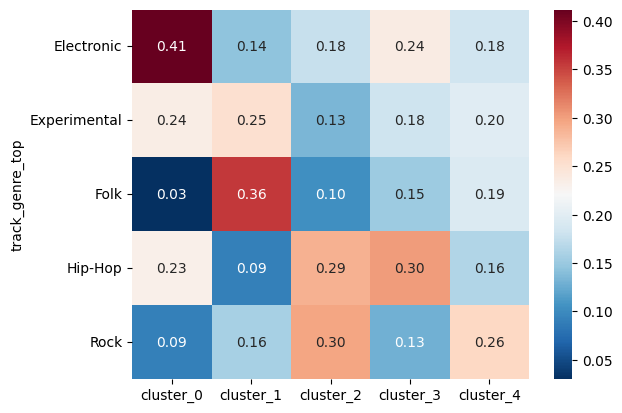

In [17]:
import seaborn as sns

sns.heatmap(
    pivot_tb / pivot_tb.sum(),
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
)

In [18]:
pivot_tb.columns = map(lambda x: x.lstrip("cluster_"), pivot_tb.columns)

In [19]:
clutser_genre_ratio = pivot_tb.div(pivot_tb.sum(axis=1), axis=0).to_dict()

In [20]:
with open("./models/pca.pkl", "wb") as f:
    pickle.dump(pca, f)

with open("./models/kmeans.pkl", "wb") as f:
    pickle.dump(kmeans, f)

with open("./models/cluster_genre_ratio.pkl", "wb") as f:
    pickle.dump(clutser_genre_ratio, f)